In [2]:
# import neccessary libraries

from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset

data = fetch_openml("credit-g", as_frame=True, parser="auto")
df = pd.concat([data.data, data.target.rename("class")], axis=1)

X = df.drop(columns=["class"])
y = df["class"]

print(df.shape)                 # expect (1000, 21)
print(X.dtypes.value_counts())  # see mix of categories/numerics
print(y.value_counts())         # counts
print((y.value_counts(normalize=True)*100).round(2))  # percentages

(1000, 21)
int64       7
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
category    1
Name: count, dtype: int64
class
good    700
bad     300
Name: count, dtype: int64
class
good    70.0
bad     30.0
Name: proportion, dtype: float64


f:\Trouble-shooting-assistant\.venv\Lib\site-packages\sklearn\datasets\_openml.py:328: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=31
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=44096

  warn(warning_msg)


In [3]:
# stratified train/validation split (80/20)

from sklearn.model_selection import train_test_split


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

for name, arr in [("X_train", X_train), ("X_valid", X_valid),
                  ("y_train", y_train), ("y_valid", y_valid)]:
    print(name, arr.shape)

X_train (800, 20)
X_valid (200, 20)
y_train (800,)
y_valid (200,)


In [4]:
# Identifying which features are categorical vs numeric for X_train

cat_cols = X_train.select_dtypes(include=['category','object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

print(len(cat_cols), "categorical"); print(len(num_cols), "numeric")
print(cat_cols)

13 categorical
7 numeric
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

cat_cols = ['checking_status','credit_history','purpose','savings_status','employment',
            'personal_status','other_parties','property_magnitude','other_payment_plans',
            'housing','job','own_telephone','foreign_worker']
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

clf = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
])

clf.fit(X_train, y_train)

proba_valid = clf.predict_proba(X_valid)
idx_bad = list(clf.named_steps["model"].classes_).index("bad")
p_bad = proba_valid[:, idx_bad]

auc = roc_auc_score((y_valid=="bad").astype(int), p_bad)
print("Validation ROC-AUC:", round(auc, 3))

Validation ROC-AUC: 0.76


In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

y_bad = (y == "bad").astype(int)  # 1 = bad (positive class), 0 = good
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y_bad, cv=cv, scoring="roc_auc")
print(scores.mean().round(3), scores.std().round(3))


0.786 0.019


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

rf = RandomForestClassifier(
    n_estimators=400, random_state=42, class_weight="balanced")

rf_clf = Pipeline([("prep", preprocess), ("model", rf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_clf, X, y_bad, cv=cv, scoring="roc_auc")
print(scores.mean().round(3), scores.std().round(3))

0.791 0.022


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_true = (y_valid=="bad").astype(int)
best = (None, 1e18)  # (t, cost)
for t in np.linspace(0,1,201):
    y_pred = (p_bad >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp*1 + fn*5
    if cost < best[1]:
        best = (t, cost)
t_star = best[0]
y_hat = (p_bad >= t_star).astype(int)
print(t_star, confusion_matrix(y_true, y_hat))
print("Precision:", precision_score(y_true, y_hat))
print("Recall:", recall_score(y_true, y_hat))


0.20500000000000002 [[77 63]
 [ 6 54]]
Precision: 0.46153846153846156
Recall: 0.9


In [9]:
from sklearn.metrics import confusion_matrix
y_true = (y_valid=="bad").astype(int)
y_hat_05 = (p_bad >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_hat_05).ravel()
print("cost@0.5 =", fp + 5*fn, "cmat:", [[tn,fp],[fn,tp]])
cost_default = 190
cost_opt = 93
reduction_pct = (cost_default - cost_opt) / cost_default * 100
print(round(reduction_pct, 1))  # → 51.1


cost@0.5 = 190 cmat: [[np.int64(115), np.int64(25)], [np.int64(33), np.int64(27)]]
51.1


In [10]:
import numpy as np
import pandas as pd

pre = clf.named_steps["prep"]
ohe = pre.named_transformers_["cat"]
# Feature names (version-safe)
try:
    cat_feats = ohe.get_feature_names_out(cat_cols)
except:
    cat_feats = ohe.get_feature_names(cat_cols)
feat_names = list(num_cols) + list(cat_feats)

coef = clf.named_steps["model"].coef_.ravel()
or_df = pd.DataFrame({"feature": feat_names, "odds_ratio": np.exp(coef)})

top_risk = or_df.sort_values("odds_ratio", ascending=False).head(5)
top_protect = or_df.sort_values("odds_ratio", ascending=True).head(5)

print("Top risk-increasing (OR>1):")
print(top_risk.to_string(index=False))
print("\nTop protective (OR<1):")
print(top_protect.to_string(index=False))


Top risk-increasing (OR>1):
                                      feature  odds_ratio
                             purpose_used car    3.871150
                  checking_status_no checking    2.712682
                      other_parties_guarantor    2.670500
credit_history_critical/other existing credit    2.324341
                            foreign_worker_no    2.053430

Top protective (OR<1):
                   feature  odds_ratio
         purpose_education    0.493475
           purpose_new car    0.506342
        checking_status_<0    0.508079
       savings_status_<100    0.587095
other_parties_co applicant    0.599541


In [11]:
from sklearn.metrics import brier_score_loss
y_true = (y_valid=="bad").astype(int)
brier = brier_score_loss(y_true, p_bad)
print("Brier score:", round(brier, 3))

p_base = np.full(y_true.shape, y_true.mean(), dtype=float)
brier_base = brier_score_loss(y_true, p_base)
print("Brier score (baseline):", round(brier_base, 3))
print("Brier skill score:", round(1 - brier / brier_base, 3))

Brier score: 0.183
Brier score (baseline): 0.21
Brier skill score: 0.129


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score

y_true = (y_valid=="bad").astype(int)

cal = CalibratedClassifierCV(estimator=clf, method='sigmoid', cv=5)
cal.fit(X_train, y_train)

proba_cal = cal.predict_proba(X_valid)
# find index of 'bad'
idx_bad = list(cal.classes_).index("bad")
p_bad_cal = proba_cal[:, idx_bad]

brier_cal = brier_score_loss(y_true, p_bad_cal)
auc_cal = roc_auc_score(y_true, p_bad_cal)
print("Calibrated Brier:", round(brier_cal, 3), "Calibrated AUC:", round(auc_cal, 3))


Calibrated Brier: 0.176 Calibrated AUC: 0.762


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_true = (y_valid == "bad").astype(int)

best_t, best_cost, best_cmat = None, float("inf"), None
for t in np.arange(0.18, 0.24, 0.001):
    y_hat = (p_bad_cal >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
    cost = fp + 5*fn
    if cost < best_cost:
        best_t, best_cost = t, cost
        best_cmat = np.array([[tn, fp], [fn, tp]])

print("t* =", round(best_t, 3), "cost =", int(best_cost))
print("cmat@t* =\n", best_cmat)
print("precision =", round(precision_score(y_true, (p_bad_cal >= best_t)), 3))
print("recall    =", round(recall_score(y_true, (p_bad_cal >= best_t)), 3))
print("t, cost reduction =", round((190 - best_cost) / 190 * 100, 1), "%")
print("cmat@0.5 =\n", confusion_matrix(y_true, (p_bad_cal >= 0.5).astype(int)))

t* = 0.21 cost = 96
cmat@t* =
 [[69 71]
 [ 5 55]]
precision = 0.437
recall    = 0.917
t, cost reduction = 49.5 %
cmat@0.5 =
 [[118  22]
 [ 33  27]]


In [28]:
print(best_cmat[0,0], best_cmat[0,1], best_cmat[1,0], best_cmat[1,1])

69 71 5 55


In [35]:
approval_rate = (best_cmat[0,0] + best_cmat[1,0]) / best_cmat.sum()
print("Approval rate at t* =", round(approval_rate, 3))
default_capture_rate = best_cmat[1,1] / (best_cmat[1,1] + best_cmat[1,0])
print("Default capture rate at t* =", round(default_capture_rate, 3))
Expected_cost = best_cmat[0,1] + best_cmat[1,0] * 5 
Expected_cost_per = Expected_cost / best_cmat.sum()
print("Expected cost at t* =", round(Expected_cost, 2))
print("Expected cost per sample at t* =", round(Expected_cost_per, 4))


Approval rate at t* = 0.37
Default capture rate at t* = 0.917
Expected cost at t* = 96
Expected cost per sample at t* = 0.48


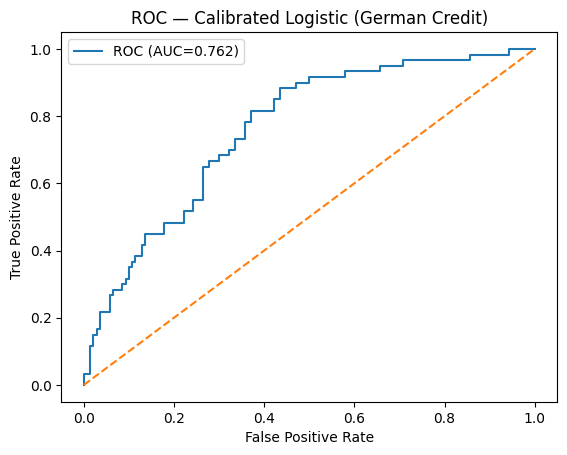

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, p_bad_cal)
auc = roc_auc_score(y_true, p_bad_cal)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Calibrated Logistic (German Credit)"); plt.legend(); plt.show()


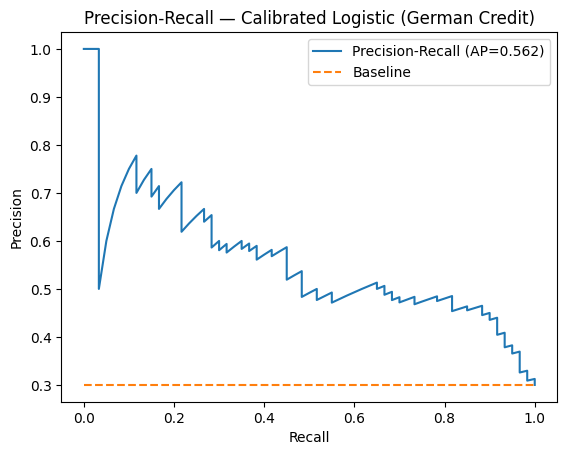

In [42]:
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_true, p_bad_cal)
avg_precision = average_precision_score(y_true, p_bad_cal)

plt.figure()
plt.plot(recall, precision, label=f"Precision-Recall (AP={avg_precision:.3f})")
plt.plot([0,1],[y_true.mean(), y_true.mean()], linestyle="--", label="Baseline")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall — Calibrated Logistic (German Credit)")
plt.legend(); plt.show()


0.089


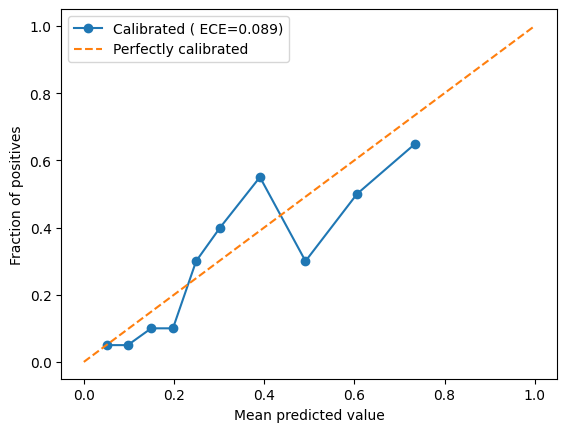

In [45]:
from sklearn.calibration import calibration_curve
fop, mpv = calibration_curve(y_true, p_bad_cal, n_bins=10, strategy="quantile")
ece = float(np.mean(np.abs(fop - mpv)))
print(round(ece, 3))
# then plot mpv vs fop with a y=x line
plt.figure()
plt.plot(mpv, fop, marker='o', label=f"Calibrated ( ECE={ece:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value"); plt.ylabel("Fraction of positives")
plt.legend(); plt.show()